## Vivacomet
**Vivacomet Notebook, is the combination of diffusion notebook and spatial dFBA notebook.** 
It simulates the environment and growth of organisms within it. The environment is represented as a grid, where each bin contains specific amounts of various molecules that organisms in that bin can utilize. The simulation takes into account the diffusion and advection of molecules, as well as the biomass of species. Additionally, Vivacomet simulates the growth of organisms in each bin, which is influenced by the availability of molecules in that bin.

In [10]:
# Standard library imports
import os
import io
import shutil
import base64

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from IPython.display import display, HTML
from PIL import Image 

# Project-Specific Imports
from processes.diffusion_field import DiffusionField
from processes.spatial_dfba import SpatialDFBA
from experiments.comets import run_comets
from plots.cometsplot import plot_elements_to_gif, combine_gifs

# Vivarium imports
from vivarium.core.engine import Engine
from vivarium.plots.topology import plot_topology

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Loaded model for Alteromonas
Writing out/composite_process_topology


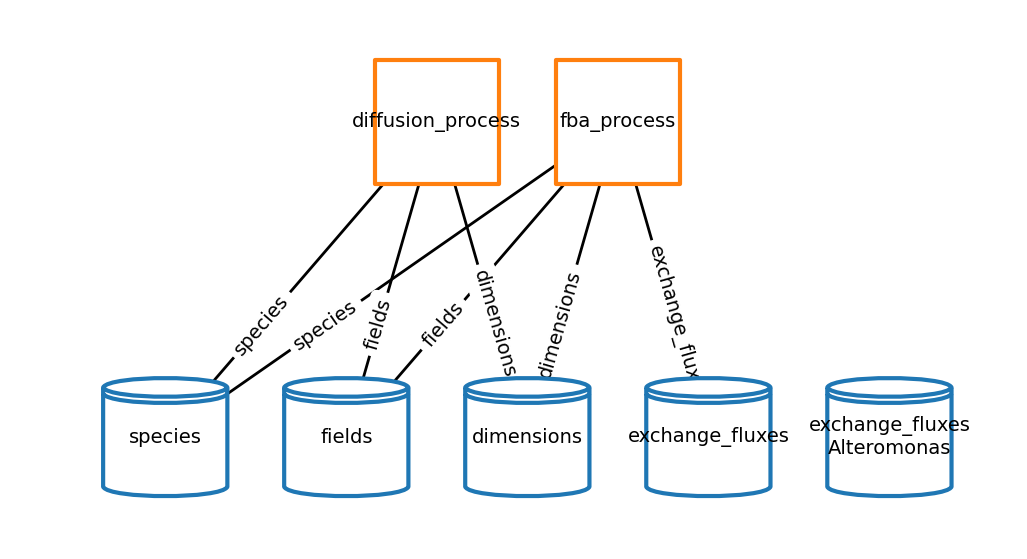

In [11]:
diffusion_field = DiffusionField({})
spatial_dfba = SpatialDFBA({'flux_id_map': {}})
composite = {
    'processes': {
        'diffusion_process': diffusion_field,
        'fba_process': spatial_dfba
    },
    'topology': {
        'diffusion_process': {
            'fields': ('fields',),
            'species': ('species',),
            'dimensions': ('dimensions',),
        },
        'fba_process': {
            'fields': ('fields',),
            'species': ('species',),
            'exchange_fluxes': ('exchange_fluxes',),
            'dimensions': ('dimensions',),
        }
    },
    'steps': {}  # Include an empty 'steps' key
}

# Plot the topology
fig = plot_topology(
    composite,
    out_dir='out',
    filename='composite_process_topology'
)

# Display the plot
plt.show()

In [12]:
# Configuration
comets_config = {
    'total_time':30 ,
    'time_step': 1,
    'bounds': [10, 4],
    'nbins': [10, 4],
    'molecules': ['glucose', 'acetate', 'Maltose'],
    'species': ['Thermotoga', 'ecoli'],
}

# Parameters shared by both processes
shared_params = {
    'bounds': comets_config['bounds'],
    'nbins': comets_config['nbins'],
    'molecules': comets_config['molecules'],
    'species':comets_config['species']
}

# Specific parameters for Diffusion Field
diffusion_field_params = {
    **shared_params,
    'default_diffusion_dt': 0.0001,
    'default_diffusion_rate': 0.0001, #2E-5,
    'diffusion': {
        'glucose': 0, #2.0E-2,
        'acetate':0, #2.0E-2,
        'Maltose':0, #2.0E-2,
        'Thermotoga': 0,#,0.5, #1.0E-2, 
        'ecoli': 0,#1, #1.0E-2 
    },
    'advection': {
        'glucose':(0, 0) , #(2.02, -0.7),
        'acetate':(0, 0) , #(2.02, -0.5),
        'Maltose': (0, 0), #(2.02, -1),
        'Thermotoga':(0, -2), # advection vector 
        'ecoli': (0, -2)
    },
    'clamp_edges': {
        'glucose': 0.5, 
        'Maltose': 0.5,
        'acetate': 10,
    }
}



# Specific parameters for Spatial DFBA
spatial_dfba_params = {
    **shared_params,
    'species_info': [
        {
            'name': 'Thermotoga',
            'model': '../data/iLJ478.xml',  # Path to FBA model file 
            'flux_id_map': {
                'glucose': 'EX_glc__D_e',
                'acetate': "EX_ac_e",
                'Maltose': "EX_malt_e"
            },
            'kinetic_params': {
                'glucose': (0.1, 1),  # Km, Vmax for glucose
                'Maltose': (0.1, 0.8)
            },
            # "fixed_bounds": {
            #     'EX_cpd00058_e0': {'lower': -1, 'upper': 1},
            # }
        },
        {
            'name': 'ecoli',
            'model': '../data/iECW_1372.xml',  # Path to E. coli model file
            'flux_id_map': {
                'glucose': 'EX_glc__D_e',
                'acetate': 'EX_ac_e',       # Exchange reaction ID for acetate
                "Maltose": "EX_malt_e"
            },
            'kinetic_params': {
                'glucose': (0.1, 1.0)  #(0.4, 5),  # Km, Vmax for glucose
                # 'acetate': (0.1, 1.0),  #(0.4, 5),  # Km, Vmax for glucose
            },
            'fixed_bounds': {
                'EX_o2_e': {'lower': -2},  # Setting fixed bounds for E. coli
                'ATPM': {'lower': 1, 'upper': 1}  # Setting fixed bounds for E. coli
            #         'EX_fe3dhbzs_e': (0, 10)  # Setting fixed bounds for E. coli
            }
        }
    ]
    
}


# Initial state configuration

initial_field_config = {
    'random': {
        'glucose': 2000.0,
        'Maltose': 2000.0,
    }
}

initial_species_config = {
    'random': {
        'species': {
            'ecoli': 0.5,
            'Thermotoga': 0.5
        }
    }
}


# Run the simulation
data = run_comets(comets_config, diffusion_field_params, spatial_dfba_params, initial_field_config, initial_species_config)

Loaded model for Thermotoga
Loaded model for ecoli
No specific initialization for molecule 'glucose', defaulting to zero.
No specific initialization for molecule 'acetate', defaulting to zero.
No specific initialization for molecule 'Maltose', defaulting to zero.

Simulation ID: 2f6cfdfc-4074-11ef-b271-ba21c95c07d9
Created: 07/12/2024 at 13:28:42
Completed in 124.71 seconds


In [13]:
data['species']['ecoli'][10][0][3]

0.06325955577434891

In [14]:
data['species']['ecoli'][10][9][3]

0.27707925739381023

## plot
This grid plot visualizes the temporal changes of biomass (E. coli, Alteromonas, and total) in the top row, while the bottom row depicts the evolving concentrations of glucose and acetate molecules across the grid, influenced by diffusion, advection, and sinking.


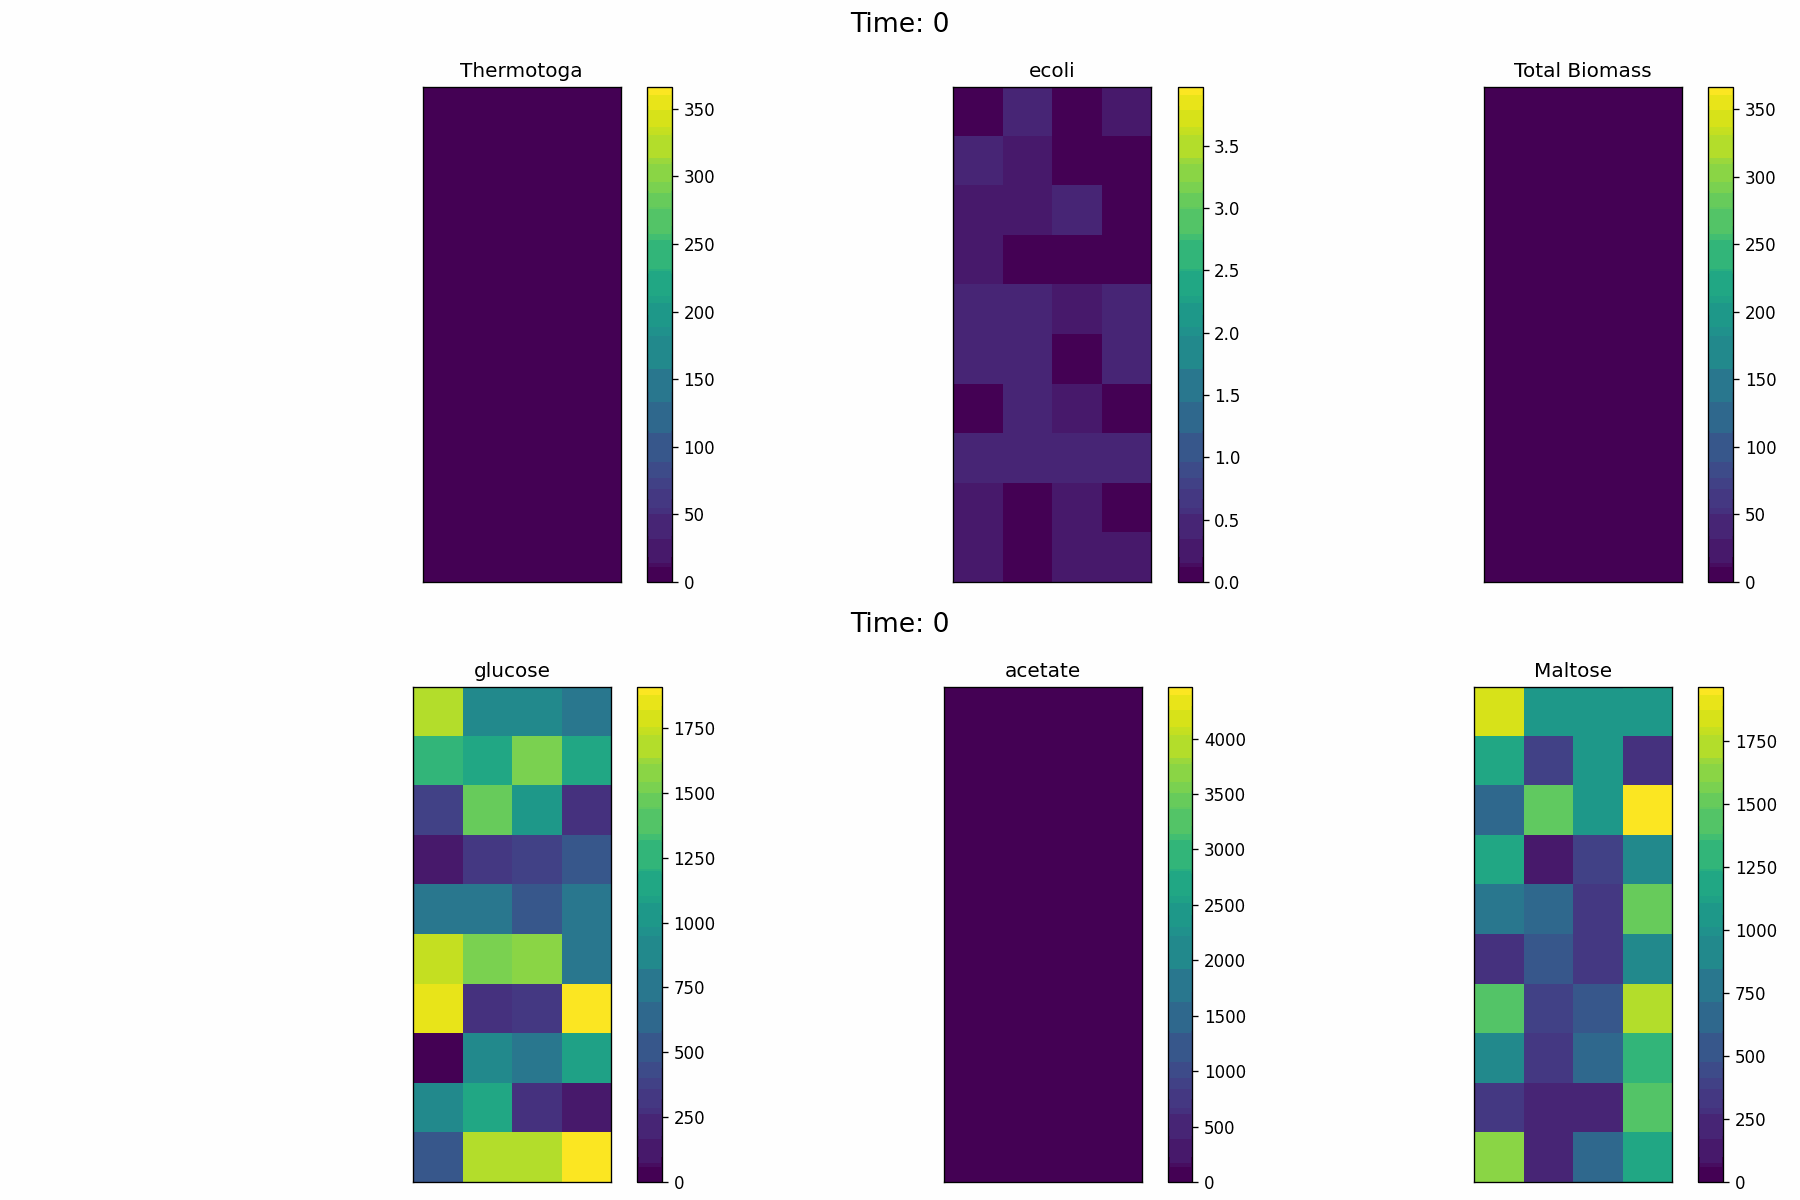

In [15]:
# Define constants and configurations
TOTAL_TIME = comets_config["total_time"]
TEMP_DIR = 'temp_images'

# Ensure the temp directory exists
os.makedirs(TEMP_DIR, exist_ok=True)

# Dynamically retrieve species and molecules from the data
species_names = [species['name'] for species in spatial_dfba_params['species_info']]
molecule_names = comets_config['molecules']

# Plot species and total biomass
plot_elements_to_gif(data, total_time=TOTAL_TIME, element_names=species_names, data_key='species', temp_dir=TEMP_DIR, file_prefix='obj_flux', include_total_biomass=True)

# Plot molecules (including 'Maltose')
plot_elements_to_gif(data, total_time=TOTAL_TIME, element_names=molecule_names, data_key='fields', temp_dir=TEMP_DIR, file_prefix='molecule')

# Combine GIFs
combine_gifs('out/combined_over_time.gif', TEMP_DIR, TOTAL_TIME + 1)

# Clean up temporary directory
shutil.rmtree(TEMP_DIR)